# This notebook is for loading GPR models and predicting observables.
# variables in this notebook:
- gpms: GP models 
- gpps: GP predictions
- sys: systematical uncertainties

In [1]:
import GPy
import pickle
import numpy as np
import matplotlib #
from numpy import *
from matplotlib import *
import pandas as pd
import warnings
import glob
import random
import time
import re
import os, sys
import csv
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import corner



# The lines below are specific to the notebook format
textsize = 25

%matplotlib inline
params = {'legend.fontsize': textsize,
          'figure.figsize': (12, 10),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot

In [2]:
# The global_kernel class is to find GP kernels which are suitable for global stellar parameters (e.g. Teff, Radius) 
#and resample them as a function of the age. 
class global_md_kernel:
    '''
    The global_kernel class aims to find an proper and efficient GP kernel for a global parameter (e. g. Teff) for
    the whole grid.  
    '''
    
    def __init__(self, datapath = None, savepath = None):
        return None
    
    def set_path(self, datapath = None,valipath = None, savepath = None):
        self._datapath = datapath
        self._valipath = valipath
        self._savepath = savepath
        
        if not os.path.exists(datapath):
            raise Warning(f'datapath:' + datapath + ' does not exist')

        if not os.path.exists(valipath):
            raise Warning(f'valipath:' + valipath + ' does not exist')
        
        if not os.path.exists(savepath): os.makedirs(savepath)
        
        print('Data path is set as' + self._datapath)
        print('Validation path is set as' + self._valipath)
        print('Save path is set as' + self._savepath)
        return self
    
    #############################################################################################################
    ################Change this function for different data formats##############################################
    #############################################################################################################
    def get_data_of_a_grid(self, path = None,
                           condition = None, number = None,
                           columns = None,
                           ranges = None,
                           normalization = None):
        if path == None:
            raise Warning(f'$path$ must be given')

        if condition == None:
            warnings.warn(f'$condition$ is missing, all csv files in datapath will be used', UserWarning)
            condition = "*.csv"
        if number == None:
            warnings.warn(f'$number$ is missing, all file will be used', UserWarning)
            number = 9999999999
            
        if (columns == None) or (ranges == None): 
            raise Warning(f'$columns$ and $ranges$ must be given')
        
        #if (validation_frac == None):
        #    warnings.warn(f'$validation_frac$ is missing, 0.2 will be used', UserWarning)
        #    validation_frac = 0.2
    
        all_files = glob.glob(path + condition)
        random.shuffle(all_files)
        n = min([int(number), len(all_files)])
        files= all_files[0:n]
        
        print(str(n) + ' tracks are found')
        
        #print('the columns names are' + str(columns))
        
        df1 = []
        
        for filename in files:
            df0 = self.get_data_of_a_track(filename = filename, 
                                           columns = columns,
                                           ranges = ranges,
                                           normalization =normalization)
            df1.append(df0)
        
        df = []    
        df = pd.concat(df1, ignore_index=True)
        
        #random_state = 1

        #if (len(df['type'])*(1 - validation_frac) >= 10000):
        #    train = df.sample( n = 10000, random_state=random_state) #random state is a seed value
        #else:
        #    train = df.sample(frac = (1 - validation_frac), random_state=random_state) #random state is a seed value
        
        #df['type'].iloc[train.index] = 'data'
        
        return df
    
    
    
    def get_data_of_a_track(self, filename = None, columns = None, ranges = None, normalization = None):
        '''
        '''        
        one_track = []
        one_track = pd.read_csv(filename)
        
        #m = re.search('yinit(.+?)MLT', filename)
        #if m:
        #    found = m.group(1)
        
        #one_track['initial_Yinit'] = float(found)                
        #get rid of the pre-MS
        #one_track = one_track.loc[one_track['center_h1'] <= 0.997*np.max(one_track['center_h1']) ]
        one_track = one_track[columns]
        #one_track['type'] = 'data'
        one_track['hrgradient'] = ((np.gradient(one_track['effective_T']/5777.0))**2.0 
                                 + (np.gradient(one_track['log_g']/4.44))**2.0
                                  )**0.5
        
        one_track['fagegradient'] = np.gradient(one_track['frac_age'])
      
        for i in range(len(columns)):
            #print(columns[i], ranges[i])
            temp = None
            temp = one_track[(one_track[columns[i]] >= min(ranges[i])) & (one_track[columns[i]] <= max(ranges[i]))]
            if (temp.shape[0] >= 10):
                one_track = one_track.loc[temp.index.min(): temp.index.max()]
                one_track['frac_age'] = one_track['star_age']/np.max(one_track['star_age'])
            else:
                one_track = None
                break
            if (normalization != None):
                if (normalization[i] > -999):
                    one_track[columns[i]] = one_track[columns[i]]/normalization[i]
        return one_track
    
    ##################### Plot section########################################################################################
    
    def preview_2d_data(self, condition = None, number = None,
                        x1 = None, x2 = None ,y = None, 
                        x1log = None, x2log = None, ylog = None, 
                        x1normalization = None, x2normalization = None, ynormalization = None,
                        savefig = None):
        
    
        
        plt.figure(figsize=(12, 10))
        plt.xlabel(x)
        plt.ylabel(x2)
        plt.title('Preview of ' + x + ' vs ' + x2 + ' color: ' + y)
        for filename in files:
            print(filename)
            gpx1, gpx2, gpy, gpx1_v, gpx2_v, gpy_v, x1range, x2range, yrange = \
            self.get_data_of_a_track(filename, x1, x2, y, x1log, x2log, ylog, \
                                     x1normalization, x2normalization, 
                                     ynormalization, fraction = 0.9)
            plt.scatter(gpx1, gpx2, c = gpy)
        if (savefig == True): plt.savefig(self._savepath + 'S00_' + x1 + '_vs_' + x2 + '_vs_' + y + 'preview.png')
        return None
    
    def plot_3d_data(self, x = None, y = None, z = None, c = None):
        fig = plt.figure()
        ax = Axes3D(fig)
        cp = ax.scatter(x, y, z, c = c, s=10)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        colorbar = plt.colorbar(cp)
        colorbar.set_label('c')
        return ax, colorbar 
    
    
   
      #####################Data generating#################
    def generate_2d_surface(self, xv = None, xvstep = None, xf1 = None, xf2 = None, number = None, factor = None):
    
        new_xv = []
        new_xf1 = []
        new_xf2 = []
    
        if factor == None: factor = 10
        
        number = min([factor*len(xv), number])
    
        for i in range(int(factor)):
            aa = xv + xvstep*(np.random.random(len(xv))-0.5)
            new_xv = np.concatenate((new_xv, aa))
            new_xf1 = np.concatenate((new_xf1, xf1))
            new_xf2 = np.concatenate((new_xf2, xf2))
            if (len(new_xv) >= number): break
    
        idxs = np.random.choice(arange(len(new_xv)), number)                           
    
    ######################GP models##################
    
    def kernel_bank(self, kname,input_dim):
        if kname == 'RBF': 
            k = GPy.kern.RBF(input_dim=input_dim, variance=1., lengthscale=1., ARD = True)
        elif kname == 'EXP': 
            k = GPy.kern.Exponential(input_dim=input_dim, variance=1., lengthscale=1., ARD = True)
        elif kname == 'MLP': 
            k = GPy.kern.MLP(input_dim=input_dim, ARD = True)
        elif kname == 'MLP+RBF':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = True)
            k2 = GPy.kern.RBF(input_dim=input_dim, variance=1., lengthscale=1., ARD = True)
            k = k1+k2
        elif kname == 'MLP+MLP':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = True)
            k2 = GPy.kern.MLP(input_dim = input_dim, ARD=True)
            k = k1+k2
        elif kname == 'MLP*MLP':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = True)
            k2 = GPy.kern.MLP(input_dim = input_dim, ARD=True)
            k = k1*k2
        elif kname == 'MLP+EXP':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = True)
            k2 = GPy.kern.Exponential(input_dim = input_dim, ARD=True)
            k = k1+k2
        elif kname == 'MLP+RQ':
            k1 = GPy.kern.MLP(input_dim=input_dim, ARD = True)
            k2 = GPy.kern.RatQuad(input_dim = input_dim, ARD=True)
            k = k1+k2
        elif kname == 'RQ':
            k = GPy.kern.RatQuad(input_dim = input_dim, ARD=True)
        elif kname == 'Mat32':
            k = GPy.kern.Matern32(input_dim = input_dim, ARD=True)
        else: 
            k = None
        return k

    
    def gp_a_dataframe(self, df = None, xcolumns = None, ycolumns = None, kname = None):
        
        start_time = time.time()
        nx = len(xcolumns)
        ny = len(ycolumns)
        #if (ny != 1):
        #    raise Warning(f'y must be 1 dimession!')

        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
        
        if (ny > 1):
            yy = df[ycolumns].to_numpy()
        else:
            yy = df[ycolumns].to_numpy().reshape(-1,1)

        kernel = self.kernel_bank(kname, nx)
        if (kernel == None):
            raise Warning('kname:'+ kanme + ' is not found')
            
        gpm = GPy.models.GPRegression(xx,yy,kernel)
        gpm.optimize()
        print("--- %s seconds ---" % (time.time() - start_time))
        return gpm
    
    ###################################################
    def load_a_gpm(self, df = None, npy = None, xcolumns = None, ycolumns = None, kname = None):
        
        nx = len(xcolumns)
        ny = len(ycolumns)

        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
        
        if (ny > 1):
            yy = df[ycolumns].to_numpy()
        else:
            yy = df[ycolumns].to_numpy().reshape(-1,1)

        kernel = self.kernel_bank(kname, nx)
        if (kernel == None):
            raise Warning('kname:'+ kanme + ' is not found')
            
        m_load = GPy.models.GPRegression(xx,yy,kernel,initialize=False)
        m_load.update_model(False) # do not call the underlying expensive algebra on load
        m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
        m_load[:] = np.load(npy) # Load the parameters
        m_load.update_model(True) # Call the algebra only once
        print(m_load)
        return m_load

    
    ######################inspecting model######################
    def inspect_gpm_on_1d(self, gpm = None, df = None, xcolumns = None, ycolumns = None):
        nx = len(xcolumns)
        ny = len(ycolumns)
        if (ny != 1):
            raise Warning(f'y must be 1 dimession!')
            
        ndf = len(df)
        
        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
        
        gpy = gpm.predict(xx)
        
        for name in xcolumns:
            fig, ax = plt.subplots(1, figsize=(6,5))
            ax.scatter(df[name], df[ycolumns],s = 10, c = 'k')
            ax.scatter(df[name], gpy[0].reshape(ndf,), s = 5, c = 'r')
            ax.set_xlabel(name)
            ax.set_ylabel(ycolumns)
        return
    
        #########################
        #####################
    
    ####
    def inspect_gpm_on_2d(self, gpm = None, df = None, xcolumns = None, ycolumns = None, xplots = None,
                          randomshift = None, shiftfactor = None, title = None):
        nx = len(xcolumns)
        ny = len(ycolumns)
        if (ny != 1):
            raise Warning(f'y must be 1 dimession!')
            
        ndf = len(df)
        
        if (nx>1):
            xx = df[xcolumns].to_numpy()
        else:
            xx = df[xcolumns].to_numpy().reshape(-1,1)
            
        if shiftfactor == None: shiftfactor = 0.01
        if randomshift == True: xx = xx + shiftfactor*xx
        
        gpy = gpm.predict(xx)
        
        nc = len(xplots)
        if nc < 2: raise Warning(f'xplots must be >=2 dimession!')
        
        for i in range(nc):
            name1 = xplots[i]
            for i2 in range(nc-i-1):
                name2 = xplots[i+i2+1]
                print(name1, name2)
                fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
                cp = ax1.scatter(df[name1], df[name2], c = (df[ycolumns[0]] - gpy[0].reshape(ndf,))/df[ycolumns[0]],s = 2)
                #ax.scatter(df[name1], df[name2], c = gpy[0].reshape(ndf,), s = 15)
                ax1.set_xlabel(name1)
                ax1.set_ylabel(name2)
                colorbar = plt.colorbar(cp)
                colorbar.set_label(ycolumns[0] + '(Grid - GP)/Grid')
                ax2.hist((df[ycolumns[0]] - gpy[0].reshape(ndf,))/df[ycolumns[0]], bins = 50)
                if title != None: ax1.set_title(title)
        return

    ######################sampling##############################
    def guassian_sample(self, obs, obs_e, howmanysigma, n):
        x = np.linspace(0,1.0,n)
        mu = 0.5
        sigma = 1.0/howmanysigma/2.0
        y = 1.0/(sigma*(2.0*np.pi)**0.5)*np.exp(-0.5*((x - mu)/sigma)**2.0)
        y = y/np.sum(y)
        data_array = (np.random.choice(n,n, p = y)/n - 0.5) *(obs_e*howmanysigma*2) + obs
        return data_array
    
    def uniform_sample(self, obs, obs_e, howmanysigma, n):
        x = np.linspace(0,1.0,n)
        mu = 0.5
        sigma = 1.0/howmanysigma/2.0
        data_array = (np.random.choice(n,n)/n - 0.5) *(obs_e*howmanysigma*2) + obs
        return data_array
    
    def linear_sample(self, start, end, slope, n):
        x = np.linspace(0,1.0,n)
        y = slope*x
        y = y/np.sum(y)
        data_array = (np.random.choice(n,n, p = y)/n) *(end - start) + start
        return data_array
    
    def age_sample(self, start, end, slope, n):
        x = np.linspace(0,1.0,n)
        y = slope*x**2
        y = y/np.sum(y)
        data_array = (np.random.choice(n,n, p = y)/n) *(end - start) + start
        return data_array
    
    def mle(self, model, obs, obs_e):
        lk = 1.0/ (2.0*3.14159*obs_e**2.0)**(0.5) * np.exp( 0.0 - (model - obs)**2.0/2.0/obs_e**2.0 )
        return lk
    
    def sample_results(self, df = None, lkname = None, f = None):
        df[lkname] = df[lkname]/np.sum(df[lkname])
        newdf = df.copy()
        for index, row in df.iterrows():
            copies = int(f*row[lkname])
            for i in range(copies):
                newdf = newdf.append(row,ignore_index=True)
        newdf.drop(index = df.index,inplace=True)
        return newdf
    
    def sample_cmd(self, gpm = None, df = None, prediction = None, 
               xcolumns = None, xshift = None, randomshift = None,
               ccolumns = None, mcolumns = None):
        nx = len(xcolumns)
        
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
        ax1.scatter(df[ccolumns], df[mcolumns],c = df[prediction], s = 5)
            
        ndf = len(df)
        
        df2 = df.copy()
        
        for name in xcolumns:
            index = xcolumns.index(name)
            if (randomshift == True):
                df2[name] = df2[name] + xshift[index]*(np.random.random(len(df2[name]))-0.5)
            else:
                df2[name] = df2[name] + xshift[index]
        
        if (nx>1):
            xx = df2[xcolumns].to_numpy()
        else:
            xx = df2[xcolumns].to_numpy().reshape(-1,1)
        
        gpp = gpm.predict(xx)
        
        ax2.scatter(df2[ccolumns],df2[mcolumns],c = gpp[0].reshape(ndf,), s = 5)
        ax1.set_xlabel(ccolumns)
        ax1.set_ylabel(mcolumns)
        ax1.set_xlim([np.max(df[ccolumns]), np.min(df[ccolumns])])
        ax2.set_xlim([np.max(df[ccolumns]), np.min(df[ccolumns])])
        ax1.set_ylim([np.max(df[mcolumns]), np.min(df[mcolumns])])
        ax2.set_ylim([np.max(df[mcolumns]), np.min(df[mcolumns])])
        ax1.set_title('Model Grid')
        ax2.set_xlabel(ccolumns)
        ax2.set_title('GP predictions')
        return 
    
    def sample_with_df(self, n = None, df = None, gpm = None, 
               xcolumns = None, xshift = None, randomshift = None,
               ycolumns = None):
        nx = len(xcolumns)
        ny = len(ycolumns)
        
        df2 = df.copy()
        if (len(df2) < n):
            for i in range(100):
                df2 = pd.concat([df2, df])
                if len(df2)>n: break
        
        df2.index = range(len(df2))
        
        ndf = len(df2)
        
        for name in xcolumns:
            index = xcolumns.index(name)
            if (randomshift == True):
                df2[name] = df2[name] + xshift[index]*(np.random.random(len(df2[name]))-0.5)
            else:
                df2[name] = df2[name] + xshift[index]
        
        if (nx>1):
            xx = df2[xcolumns].to_numpy()
        else:
            xx = df2[xcolumns].to_numpy().reshape(-1,1)
        
        gpp = gpm.predict(xx)
        df2[ycolumns] = gpp[0]
        df2['gp_var'] = gpp[1].reshape(ndf,)
        
        #for yname in ycolumns:
        #    index = ycolumns.index(yname)
        #    gpp = gpm[index].predict(xx)
        #    df2[yname] = gpp[0].reshape(ndf,)
        #    df2[yname + '_var'] = gpp[1].reshape(ndf,)
        return df2



In [7]:
xcolumns = ['initial_mass','frac_age', 'initial_zx', 'initial_Yinit', 'initial_MLT']
#ycolumns = ['effective_T','log_g','radius', 'star_age','star_zx', 'delta_nu_fit']
ycolumns = ['effective_T'] ###!!!
xshifts = [0.0,0.0,0.0,0.0,0.0]

sysfile = 'M2_RBF_offsets_.csv' ###!!!

ntraining = 10000
nvalidating = 20000
nresidual = 100000

In [8]:
datadr = '/Users/litz/Documents/GitHub/GPGrid_paper/GPR_model/5d_gpr_models/' + ycolumns[0] + '/'
savedr = '/Users/litz/Documents/GitHub/GPGrid_paper/GPR_model/5d_gpr_models/' + ycolumns[0] + '/'
validr = '/Users/litz/Documents/GitHub/GPGrid_paper/GPR_model/5d_gpr_models/'
gmk = global_md_kernel()
gmk.set_path(datapath = datadr, savepath = savedr, valipath = validr)

Data path is set as/Users/litz/Documents/GitHub/GPGrid_paper/GPR_model/5d_gpr_models/effective_T/
Validation path is set as/Users/litz/Documents/GitHub/GPGrid_paper/GPR_model/5d_gpr_models/
Save path is set as/Users/litz/Documents/GitHub/GPGrid_paper/GPR_model/5d_gpr_models/effective_T/


In [11]:
# Train and validate
def train_and_validate(gdf, dfv, kname, label):
    print('training ' + label)
    gpm = gmk.gp_a_dataframe(df = gdf, xcolumns = xcolumns, ycolumns = ycolumns, kname = kname)
    #
    np.save(gmk._savepath + label + '_gpm_.npy', gpm.param_array)
    gdf.to_csv(gmk._savepath + label + '_gpm_.csv')
    #
    print('validating ...')
    gpp = dfv.copy()
    offsets = dfv.copy()
    gpp = gmk.sample_with_df(n = 1, df = dfv, gpm = gpm,
                             xcolumns = xcolumns, xshift = xshifts,
                             randomshift = False, ycolumns = ycolumns)
    gpp.to_csv(gmk._savepath + label + '_gpp_.csv')
    offsets[ycolumns] = dfv[ycolumns] - gpp[ycolumns]
    offsets.to_csv(gmk._savepath + label + '_offsets_.csv')
    validations = np.percentile(np.abs(offsets[ycolumns]), [50, 95, 99.8, 100])
    print('Model---50%----95%---99.8%---100%')
    print(label, validations)
    #
    fig, ax = plt.subplots(1,1, figsize = (10,9))
    cp = ax.scatter(dfv['initial_mass'], dfv['frac_age'], c = offsets[ycolumns[0]],s = 10)
    ax.set_xlabel(r'Mass (M$_{\odot}$)')
    ax.set_ylabel(r"$t'$")
    #ax.set_xlim([7000,4750])
    #ax.set_ylim([4.7,3.7])
    cc = plt.colorbar(cp)
    cc.set_label(ycolumns[0])
    ax.set_title(label)
    #ax.legend(fontsize = 20)
    fig.tight_layout()
    fig.savefig(gmk._savepath + label +'validation.pdf')

    return gpm, gpp, offsets, validations


In [23]:
df = pd.read_csv(savedr + sysfile)
df['weights'] = np.abs(df[ycolumns[0]])

gdfsys = df.sample(n = ntraining, weights = 'weights', random_state = 500)
dfvsys = df.drop(gdfsys.index)

gdfsys.index = range(len(gdfsys))
dfvsys.index = range(len(dfvsys))

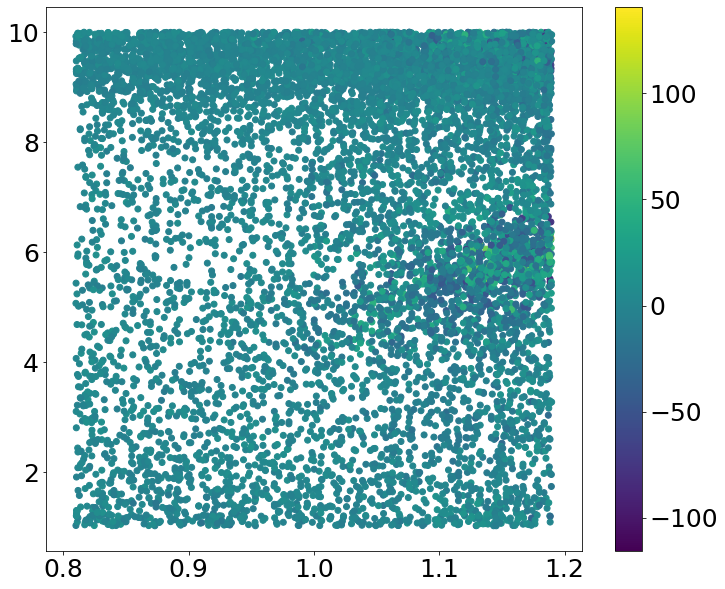

In [24]:
cp = plt.scatter(gdfsys['initial_mass'], gdfsys['frac_age'], c = gdfsys[ycolumns[0]])
plt.colorbar(cp)

In [ ]:
knames = ['MLP'] #, 'EXP', 'RBF', 'RQ','Mat32']
for kname in knames:
    label = 'Msys_' + kname
    gpmsys, gppsys, offsetssys, validationssys = train_and_validate(gdfsys, dfvsys, kname, label)

training MsysMLP
